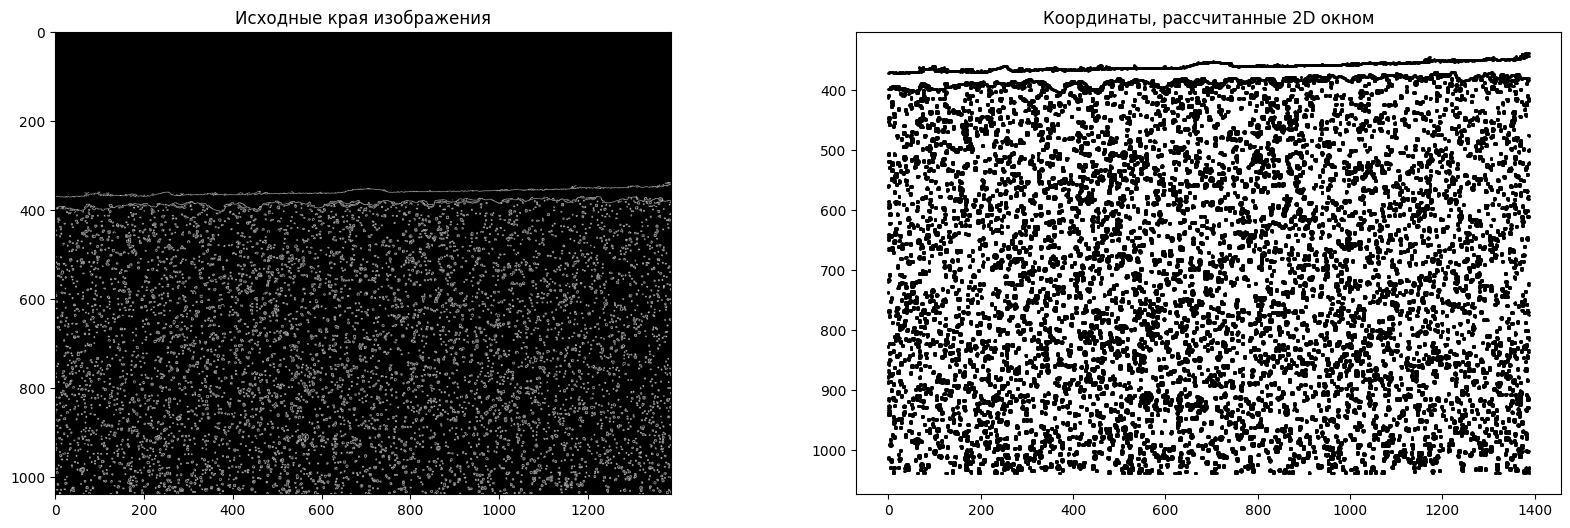

Координаты края сохранены в 'coordinates_rolling_window11.csv'
Сохранение расширенного набора данных в 'expanded_coordinates11.csv'


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Функция для 2D скользящего окна
def roll(a, b, dx=1, dy=1):
    shape = a.shape[:-2] + ((a.shape[-2] - b.shape[-2]) // dy + 1,) + ((a.shape[-1] - b.shape[-1]) // dx + 1,) + b.shape
    strides = a.strides[:-2] + (a.strides[-2] * dy,) + (a.strides[-1] * dx,) + a.strides[-2:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Функция для расчета координат края с помощью скользящего окна
def calculate_edge_coordinates(edge_image, window_size=(1, 1)):
    window = np.ones(window_size)
    rolled_edges = roll(edge_image, window, dx=1, dy=1)
    coordinates = []
    for i in range(rolled_edges.shape[0]):
        for j in range(rolled_edges.shape[1]):
            window_data = rolled_edges[i, j]
            if np.any(window_data):
                coordinates.append((j * window_size[1], i * window_size[0]))
    return np.array(coordinates)

# Функция для записи координат в CSV-файл
def save_coordinates_to_csv(coordinates,
                            filename='/content/drive/MyDrive/Colab Notebooks/content/dataset/с/coordinate11.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["X", "Y"])  # Заголовки
        for coord in coordinates:
            writer.writerow(coord)


# Загрузка изображения
image_path = '/content/drive/MyDrive/Colab Notebooks/content/dataset/class1/11.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # Применение алгоритма Кэнни для выделения краев
edges = cv2.Canny(image, threshold1=50, threshold2=150)

# # Поиск контуров на изображении
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Извлечение координат x и y для контуров
x_coords = []
y_coords = []

for contour in contours:
    for point in contour:
        x, y = point[0]
        x_coords.append(x)
        y_coords.append(y)


# Использование функции calculate_edge_coordinates для извлечения координат с помощью 2D окна
coordinates = calculate_edge_coordinates(edges, window_size=(1, 1))

# Сохранение полученных координат в CSV
save_coordinates_to_csv(coordinates, '/content/drive/MyDrive/Colab Notebooks/content/dataset/class2/coordinates_rolling_window11.csv')

# Преобразование координат для визуализации
x_coords = coordinates[:, 0]
y_coords = coordinates[:, 1]

#Сохранение расширенного набора данных

data = pd.DataFrame({'X': x_coords, 'Y': y_coords})
data.to_csv('/content/drive/MyDrive/Colab Notebooks/content/dataset/coordinates1/expanded_coordinates11.csv', index=False)


# Сохранение координат в CSV-файл
data.to_csv('edge_coordinates11.csv', index=False)

# Создание визуализаций
plt.figure(figsize=(20, 6))

# Визуализация 1: Исходные края
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Исходные края изображения")

# Визуализация 2: Координаты, полученные с помощью скользящего окна
plt.subplot(1, 2, 2)
plt.scatter(x_coords, y_coords, color='black', s=1)  # Выделение координат контуров
plt.gca().invert_yaxis()
plt.title("Координаты, рассчитанные 2D окном")

plt.show()

print("Координаты края сохранены в 'coordinates_rolling_window11.csv'")
print("Сохранение расширенного набора данных в 'expanded_coordinates11.csv'")

#[Сканирующее окно ](https://habr.com/ru/articles/489734/)

# Дополнительно можно записывать изображения отображенных координат

##Создание пустого изображения для отображения координат (бинарное изображение с белым фоном)
```
output_image = np.zeros_like(image, dtype=np.uint8)
```
## Нанесение найденных координат на пустое изображение
```
for x, y in coordinates:
     output_image[y, x] = 255
```
## Сохранение изображения с нанесенными координатами
```
output_path = '/content/drive/MyDrive/Colab Notebooks/content/dataset/processed_coordinate_image'
cv2.imwrite(output_path, output_image)
print(f"Обработанное изображение с координатами сохранено в {output_path}")
```



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression

# Параметры для перекрытия и угла наклона
OVERLAP_THRESHOLD = 10  # Порог пикселей для поиска перекрытия
ROTATE_CORRECTION = True  # Флаг для коррекции угла наклона

#не находит перекрытие из-за одинаковых координат на каждом снимке и эта обработка нужна компьютерным зрением, не через координаты

# Функция для загрузки данных и нахождения перекрытия между соседними фрагментами
def load_and_align_data(file_paths):
    all_data = []
    shifts_x, shifts_y = [], []

    for i, file_path in enumerate(file_paths):
        data = pd.read_csv(file_path)
        x = data['X'].values
        y = data['Y'].values

        # Если это не первый фрагмент, находим перекрытие с предыдущим фрагментом
        if i > 0:
            prev_x, prev_y = all_data[-1][:, 0], all_data[-1][:, 1]
            overlap_idx = np.where((abs(x[:OVERLAP_THRESHOLD] - prev_x[-OVERLAP_THRESHOLD:]) < OVERLAP_THRESHOLD) &
                                   (abs(y[:OVERLAP_THRESHOLD] - prev_y[-OVERLAP_THRESHOLD:]) < OVERLAP_THRESHOLD))[0]

            # Проверяем, найдено ли перекрытие
            if overlap_idx.size > 0:
                # Вычисляем смещение по X и Y
                shift_x = np.mean(x[overlap_idx] - prev_x[-len(overlap_idx):])
                shift_y = np.mean(y[overlap_idx] - prev_y[-len(overlap_idx):])

                shifts_x.append(shift_x)
                shifts_y.append(shift_y)

                # Применяем смещение ко всему фрагменту
                x = x - shift_x
                y = y - shift_y
            else:
                print(f"Предупреждение: перекрытие не найдено между фрагментами {i-1} и {i}")
                shifts_x.append(0)
                shifts_y.append(0)

        # Объединяем данные
        aligned_data = np.column_stack((x, y))
        all_data.append(aligned_data)

    # Конкатенация всех данных в один массив
    all_data = np.vstack(all_data)
    return all_data, shifts_x, shifts_y

# Функция для вычисления угла наклона и поворота координат
def correct_tilt(data):
    x, y = data[:, 0], data[:, 1]
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    tilt_angle = np.arctan(model.coef_[0])  # Угол наклона в радианах
    print(f"Угол наклона (рад): {tilt_angle}")

    # Коррекция угла наклона
    rotation_matrix = np.array([[np.cos(-tilt_angle), -np.sin(-tilt_angle)],
                                [np.sin(-tilt_angle),  np.cos(-tilt_angle)]])
    corrected_coords = data @ rotation_matrix
    return corrected_coords

# Сохранение скорректированного датасета в файл CSV
def save_corrected_data(data, filename='corrected_dataset.csv'):
    corrected_df = pd.DataFrame(data, columns=['X', 'Y'])
    corrected_df.to_csv(filename, index=False)
    print(f"Скорректированный датасет сохранен как '{filename}'")

# Загрузка и корректировка данных
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/content/dataset/class2/coordinates_rolling_window*.csv')
data, shifts_x, shifts_y = load_and_align_data(file_paths)

# Коррекция угла наклона (если указано)
if ROTATE_CORRECTION:
    data = correct_tilt(data)

# Сохранение корректированного датасета
save_corrected_data(data, filename='/content/drive/MyDrive/Colab Notebooks/content/dataset/class3/corrected_dataset.csv')


Предупреждение: перекрытие не найдено между фрагментами 0 и 1
Предупреждение: перекрытие не найдено между фрагментами 1 и 2
Предупреждение: перекрытие не найдено между фрагментами 2 и 3
Предупреждение: перекрытие не найдено между фрагментами 3 и 4
Предупреждение: перекрытие не найдено между фрагментами 4 и 5
Предупреждение: перекрытие не найдено между фрагментами 5 и 6
Предупреждение: перекрытие не найдено между фрагментами 6 и 7
Предупреждение: перекрытие не найдено между фрагментами 7 и 8
Предупреждение: перекрытие не найдено между фрагментами 8 и 9
Предупреждение: перекрытие не найдено между фрагментами 9 и 10
Угол наклона (рад): -0.00449196671359818
Скорректированный датасет сохранен как '/content/drive/MyDrive/Colab Notebooks/content/dataset/class3/corrected_dataset.csv'


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16166/16166 - 33s - 2ms/step - loss: 52546.2383 - mae: 188.7469 - val_loss: 41064.3711 - val_mae: 174.1113
Epoch 2/50
16166/16166 - 30s - 2ms/step - loss: 40265.9375 - mae: 172.5531 - val_loss: 39275.2969 - val_mae: 171.4157
Epoch 3/50
16166/16166 - 38s - 2ms/step - loss: 39992.5352 - mae: 172.1528 - val_loss: 39973.2031 - val_mae: 172.0316
Epoch 4/50
16166/16166 - 46s - 3ms/step - loss: 39892.8047 - mae: 172.0560 - val_loss: 38680.1406 - val_mae: 170.5034
Epoch 5/50
16166/16166 - 30s - 2ms/step - loss: 39805.4375 - mae: 171.9039 - val_loss: 46301.6914 - val_mae: 182.0152
Epoch 6/50
16166/16166 - 39s - 2ms/step - loss: 39666.6680 - mae: 171.7054 - val_loss: 38778.8828 - val_mae: 170.4722
Epoch 7/50
16166/16166 - 28s - 2ms/step - loss: 39588.5781 - mae: 171.5726 - val_loss: 40667.0117 - val_mae: 173.5656
Epoch 8/50
16166/16166 - 40s - 2ms/step - loss: 39459.0742 - mae: 171.4386 - val_loss: 38718.7539 - val_mae: 170.4554
Epoch 9/50
16166/16166 - 32s - 2ms/step - loss: 39434.1953 - mae: 1

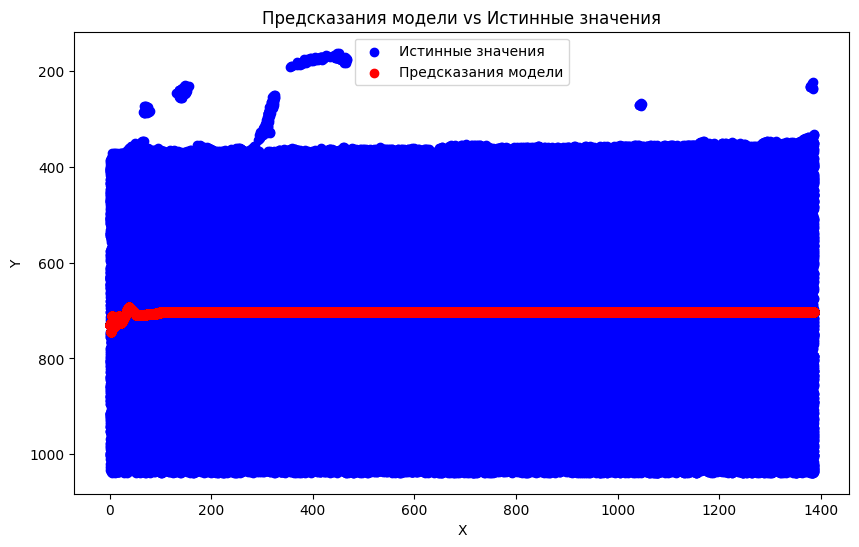

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import glob

# Загрузка и объединение всех CSV файлов
path = '/content/drive/MyDrive/Colab Notebooks/content/dataset/class3/'  # путь к директории с CSV файлами
all_files = glob.glob(path + "corrected_dataset.csv")  # загружаем все файлы, удовлетворяющие шаблону

data_list = []  # создаем список для хранения данных из всех файлов

for filename in all_files:
    df = pd.read_csv(filename)
    data_list.append(df)

# Объединяем все DataFrame в один

data = pd.concat(data_list, ignore_index=True)
# # Загрузка и подготовка данных одно изображение
# uploaded = files.upload()
# csv_file_name = '/content/drive/MyDrive/Colab Notebooks/content/dataset/class2/coordinates_rolling_window1.csv'
# data = pd.read_csv(csv_file_name)
# print(data.head())

input_data = np.arange(len(data)).reshape(-1, 1)
x_coords = data['X'].values
y_coords = data['Y'].values

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x_coords, y_coords, test_size=0.2, random_state=42)

# Преобразование данных для использования в модели
x_train = x_train.reshape(-1, 1)  # Преобразуем x_train в 2D массив
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#Построение модели для регрессии
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(1,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))  # выход: для предсказания Y

# Компиляция модели с функцией потерь MSE для регрессии
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=2)

# Оценка модели на тестовой выборке
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
print("Средняя абсолютная ошибка на тестовых данных: %.2f" % test_mae)


# Визуализация предсказаний
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='blue', label='Истинные значения')
plt.scatter(x_test, y_pred, color='red', label='Предсказания модели')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title("Предсказания модели vs Истинные значения")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import cv2
import numpy as np
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
import os

# Параметры для коррекции и поиска перекрытия
MIN_MATCH_COUNT = 10  # Минимальное количество совпадений для нахождения перекрытия
ROTATE_CORRECTION = True

# Функция для нахождения смещения между двумя изображениями через ORB
def find_shift_with_orb(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) >= MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
        if M is not None:
            shift_x, shift_y = M[0, 2], M[1, 2]
            return shift_x, shift_y
    return None, None

# Функция для последовательного склеивания изображений по порядку номеров
def process_and_align_images_in_order(file_paths):
    aligned_data = []
    previous_image = None
    previous_data = None

    for i, file_path in enumerate(file_paths):
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Извлекаем координаты краев для текущего изображения
        y_coords, x_coords = np.where(cv2.Canny(image, 50, 150) > 0)
        current_data = np.column_stack((x_coords, y_coords))

        # Если это не первое изображение, то находим перекрытие с предыдущим и выравниваем
        if previous_image is not None:
            shift_x, shift_y = find_shift_with_orb(previous_image, image)
            if shift_x is not None and shift_y is not None:
                print(f"Фрагмент {i + 1}: смещение по X: {shift_x}, смещение по Y: {shift_y}")

                # Корректируем текущие координаты по смещению
                current_data[:, 0] += shift_x
                current_data[:, 1] += shift_y

        # Объединяем текущие данные с предыдущими
        if previous_data is None:
            aligned_data = current_data
        else:
            aligned_data = np.vstack((aligned_data, current_data))

        # Обновляем предыдущее изображение и данные для следующего шага
        previous_image = image
        previous_data = current_data

    return aligned_data

# Коррекция наклона (по необходимости)
def correct_tilt(data):
    x, y = data[:, 0], data[:, 1]
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    tilt_angle = np.arctan(model.coef_[0])
    print(f"Угол наклона (рад): {tilt_angle}")

    rotation_matrix = np.array([[np.cos(-tilt_angle), -np.sin(-tilt_angle)],
                                [np.sin(-tilt_angle),  np.cos(-tilt_angle)]])
    return data @ rotation_matrix

# Сохранение корректированного датасета
def save_corrected_data(data, filename='corrected_dataset.csv'):
    corrected_df = pd.DataFrame(data, columns=['X', 'Y'])
    corrected_df.to_csv(filename, index=False)
    print(f"Скорректированный датасет сохранен как '{filename}'")

# Получение списка файлов в порядке их номеров
file_paths = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/content/dataset/class2/*.jpg'), key=lambda x: int(os.path.basename(x).split('.')[0]))

# Обработка изображений в порядке номеров
data = process_and_align_images_in_order(file_paths)

# Коррекция угла наклона (если указано)
if ROTATE_CORRECTION:
    data = correct_tilt(data)

# Сохранение данных
save_corrected_data(data, filename='/content/drive/MyDrive/Colab Notebooks/content/dataset/class3/corrected_dataset.csv')


In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD


import cv2
import numpy as np
import matplotlib.pyplot as plt


# Загрузка изображения
image_path = '/content/dataset/class1/1.jpg'
image = cv2.imread(image_path)

# Преобразование в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применение метода Canny для обнаружения краев
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

# Создание маски (сохранение краев в черно-белом изображении)
mask = np.zeros_like(image)
mask[edges != 0] = [255, 255, 255]  # Изменяем цвет на белый для краев

# Извлечение края из оригинального изображения
result = cv2.bitwise_and(image, mask)

# Отображение изображений
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Edges Detected')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Extracted Edges')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# Сохранение результата
output_path = '/content/dataset/class1/output.jpg'

cv2.imwrite(output_path, result)

# Задаем seed для повторяемости результатов
numpy.random.seed(42)

# Загружаем данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Размер мини-выборки
batch_size = 32
# Количество классов изображений
nb_classes = 10
# Количество эпох для обучения
nb_epoch = 25
# Размер изображений
img_rows, img_cols = 32, 32
# Количество каналов в изображении: RGB
img_channels = 3

# Нормализуем данные
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Преобразуем метки в категории
Y_train = to_categorical(y_train, 10)  # Используем to_categorical вместо np_utils.to_categorical
Y_test = to_categorical(y_test, 10)

# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same',
                        input_shape=(32, 32, 3), activation='relu'))
# Второй сверточный слой
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))

# Задаем параметры оптимизации
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
# Обучаем модель
model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))
# Параметры
image_size = (1388, 1040)  # Размер изображений
batch_size = 2            # Размер пакета для обучения

# Создание генератора данных с аугментацией
data_gen = ImageDataGenerator(
    rescale=1./255,         # Нормализация изображений
    rotation_range=20,      # Угол поворота
    width_shift_range=0.2,  # Сдвиг по ширине
    height_shift_range=0.2, # Сдвиг по высоте
    shear_range=0.2,       # Сдвиг
    zoom_range=0.2,        # Масштабирование
    horizontal_flip=True,   # Отражение
    fill_mode='nearest'     # Режим заполнения
)

# Загрузка данных из каталога
train_data = data_gen.flow_from_directory(
    '/content/dataset/class1',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  )
# Создание модели
model = models.Sequential()
# Define input dimensions
height =1388
width = 1040
channels = 3
# Слой 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model.add(layers.MaxPooling2D((2, 2)))

# Слой 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Слой 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Полносвязный слой
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

# Выходной слой
model.add(layers.Dense(1))  # Прогнозируем одно значение

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_split=0.1, verbose=2)

# Оценка модели
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1] * 100))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

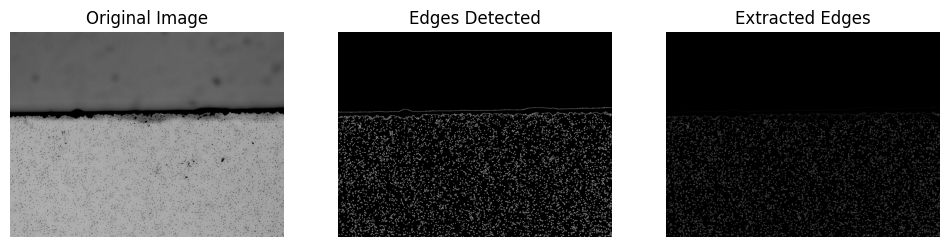

Epoch 1/25
1407/1407 - 13s - 9ms/step - accuracy: 0.4353 - loss: 1.5418 - val_accuracy: 0.5680 - val_loss: 1.1897
Epoch 2/25
1407/1407 - 14s - 10ms/step - accuracy: 0.5942 - loss: 1.1307 - val_accuracy: 0.6456 - val_loss: 0.9973
Epoch 3/25
1407/1407 - 10s - 7ms/step - accuracy: 0.6554 - loss: 0.9712 - val_accuracy: 0.7020 - val_loss: 0.8619
Epoch 4/25
1407/1407 - 5s - 4ms/step - accuracy: 0.6885 - loss: 0.8794 - val_accuracy: 0.7188 - val_loss: 0.8014
Epoch 5/25
1407/1407 - 5s - 4ms/step - accuracy: 0.7181 - loss: 0.8072 - val_accuracy: 0.7340 - val_loss: 0.7780
Epoch 6/25
1407/1407 - 10s - 7ms/step - accuracy: 0.7331 - loss: 0.7604 - val_accuracy: 0.7660 - val_loss: 0.6862
Epoch 7/25
1407/1407 - 5s - 4ms/step - accuracy: 0.7475 - loss: 0.7178 - val_accuracy: 0.7594 - val_loss: 0.6834
Epoch 8/25
1407/1407 - 5s - 4ms/step - accuracy: 0.7608 - loss: 0.6745 - val_accuracy: 0.7618 - val_loss: 0.6842
Epoch 9/25
1407/1407 - 5s - 4ms/step - accuracy: 0.7733 - loss: 0.6456 - val_accuracy: 0.78

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Загрузка изображения
image_path = '/content/dataset/class1/1.jpg'
image = cv2.imread(image_path)

# Преобразование в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применение метода Canny для обнаружения краев
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

# Создание маски (сохранение краев в черно-белом изображении)
mask = np.zeros_like(image)
mask[edges != 0] = [255, 255, 255]  # Изменяем цвет на белый для краев

# Извлечение края из оригинального изображения
result = cv2.bitwise_and(image, mask)

# Отображение изображений
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Edges Detected')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Extracted Edges')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

# Сохранение результата
output_path = '/content/output_image.png'
cv2.imwrite(output_path, result)

# Загружаем данные CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)

# Создаем последовательную модель
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_split=0.1, verbose=2)

# Оценка модели
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1] * 100))

# Создание генератора данных с аугментацией
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Загрузка данных из каталога

train_data = data_gen.flow_from_directory(
    '/content/dataset/class1',
    target_size=(1388, 1040),  #  в соответствии с размером изображений
    batch_size=32,
    class_mode='categorical'  # Изменить на 'regression' для задачи регрессии
)



In [ ]:
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Настройка модели
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Прогноз для изображения
image = cv2.imread('')
outputs = predictor(image)

# Получаем маски объектов
masks = outputs["instances"].pred_masks.to("cpu").numpy()


In [ ]:
import csv

from PIL import Image  # Для работы с изображениями .jpg
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy.ndimage import gaussian_filter, median_filter

# Rolling 2D window
def roll(a, b, dx=1, dy=1):
    shape = a.shape[:-2] + ((a.shape[-2] - b.shape[-2]) // dy + 1,) + ((a.shape[-1] - b.shape[-1]) // dx + 1,) + b.shape
    strides = a.strides[:-2] + (a.strides[-2] * dy,) + (a.strides[-1] * dx,) + a.strides[-2:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Координаты границ
def calculate_edge_coordinates(edge_image, window_size=(10, 10)):
    window = np.ones(window_size)
    rolled_edges = roll(edge_image, window)
    coordinates = []
    for i in range(rolled_edges.shape[0]):
        for j in range(rolled_edges.shape[1]):
            window_data = rolled_edges[i, j]
            if np.any(window_data):
                coordinates.append((j * window_size[1], i * window_size[0]))
    return np.array(coordinates)
# Функция для записи координат в CSV-файл
def save_coordinates_to_csv(coordinates, filename='/content/drive/MyDrive/Colab Notebooks/content/dataset/class1/coordinates.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["X", "Y"])  # Заголовки
        for coord in coordinates:
            writer.writerow(coord)

# Сохраняем координаты в файл
save_coordinates_to_csv(coordinates)

# Функция для расчета среднеквадратичной шероховатости (Rq) на основе координат края
def calculate_rms_roughness_from_coordinates(coordinates, pixel_size):
    if len(coordinates) == 0:
        raise ValueError("Нет координат края для расчета.")
    mean_height = np.mean(coordinates[:, 1])  # Среднее значение высоты
    squared_deviations = (coordinates[:, 1] - mean_height) ** 2  # Отклонения по высоте
    rms_roughness = np.sqrt(np.mean(squared_deviations)) * pixel_size
    rms_error1 = bootstrap_std(np.sqrt(squared_deviations).flatten()) * pixel_size  # Преобразуем в одномерный массив
    return rms_roughness, rms_error1

# Аналогично для Ra и Rz
def calculate_arithmetic_roughness_from_coordinates(coordinates, pixel_size):
    mean_height = np.mean(coordinates[:, 1])
    deviations = np.abs(coordinates[:, 1] - mean_height)
    ra_roughness = np.mean(deviations) * pixel_size
    ra_error = np.std(deviations) * pixel_size
    return ra_roughness, ra_error

def calculate_max_height_roughness_from_coordinates(coordinates, pixel_size):
    min_height = np.min(coordinates[:, 1])
    max_height = np.max(coordinates[:, 1])
    rz = (max_height - min_height) * pixel_size
    rz_error = bootstrap_std(coordinates[:, 1]) * pixel_size
    return rz, rz_error
# Загружаем изображение в формате .jpg с помощью PIL
def load_image_jpg(image_path):
    image = Image.open(image_path).convert('L')
    image_data = np.array(image, dtype=np.float64)  # Преобразуем в numpy массив
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    return image_data


image_path = '/content/drive/MyDrive/Colab Notebooks/content/dataset/class1/1.jpg'
pixel_size = 3.5
image_data = load_image_jpg(image_path)
edge_image = extract_edge(image_data)
coordinates = calculate_edge_coordinates(edge_image)

# Вычисление шероховатостей по координатам края
rms_roughness_value, rms_error1 = calculate_rms_roughness_from_coordinates(coordinates, pixel_size)
arithmetic_roughness_value, ra_error = calculate_arithmetic_roughness_from_coordinates(coordinates, pixel_size)
max_height_roughness_value, rz_error = calculate_max_height_roughness_from_coordinates(coordinates, pixel_size)


NameError: name 'coordinates' is not defined

#Расчет шероховатости на 1 одном снимке с применением бустрэпирования, фильтра Собеля и бинаризации. Вывод бинаризованного изображения и сохранение результа в файл .txt

In [ ]:

from PIL import Image  # Для работы с изображениями .jpg
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters, measure
from scipy.ndimage import gaussian_filter


# Функция бутстрэп для вычисления погрешности
def bootstrap_std(data, num_samples=1000):
    data_1d = data.flatten()  # Преобразуем массив в одномерный
    if len(data_1d) == 0:  # Проверяем, что данные не пустые
        raise ValueError("Пустой массив данных для бутстрэпирования.")

    # Применяем бутстрэп к одномерному массиву
    bootstrap_samples = np.random.choice(data_1d, size=(num_samples, len(data_1d)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    return np.std(bootstrap_means)
# Функция для расчета среднеквадратичной шероховатости (Rq)
def calculate_rms_roughness(edge_image, pixel_size):
    """
    Вычисление среднеквадратичной шероховатости (Rq) по краевому изображению.
    :param edge_image: 2D массив изображения краевой части
    :param pixel_size: размер пикселя (в микрометрах)
    :return: значение Rq (в микрометрах)
    """
    if edge_image.size == 0:  # Проверяем, что изображение не пустое
        raise ValueError("Пустое изображение!")

    smoothed_image = gaussian_filter(edge_image.astype(np.float64), sigma=1)
    mean_height = np.mean(smoothed_image)
    squared_deviations = (smoothed_image - mean_height) ** 2

    rms_roughness = np.sqrt(np.mean(squared_deviations)) * pixel_size

    # Используем одномерные данные для бутстрэпирования

    rms_error1 = bootstrap_std(np.sqrt(squared_deviations)) * pixel_size

    return rms_roughness, rms_error1

# Функция для расчета средней арифметической шероховатости (Ra)
def calculate_arithmetic_roughness(edge_image, pixel_size):
    """
    Вычисление средней арифметической шероховатости (Ra).
    :param edge_image: 2D массив изображения краевой части
    :param pixel_size: размер пикселя (в микрометрах)
    :return: значение Ra (в микрометрах)
    """
    smoothed_image = gaussian_filter(edge_image, sigma=1)
    mean_height = np.mean(smoothed_image)
    deviations = np.abs(smoothed_image - mean_height)
    ra_roughness = np.mean(deviations) * pixel_size
    # Погрешность как стандартное отклонение отклонений
    error = np.std(deviations) * pixel_size
    return ra_roughness, error
# Функция для расчета максимальной высоты профиля (Rz)
def calculate_max_height_roughness(edge_image, pixel_size):
    """
    Вычисление максимальной высоты профиля (Rz).
    :param edge_image: 2D массив изображения краевой части
    :param pixel_size: размер пикселя (в микрометрах)
    :return: значение Rz (в микрометрах)
    """
    heights = np.argmax(edge_image, axis=0)
    min_height = np.min(heights)
    max_height = np.max(heights)
    rz = (max_height - min_height) * pixel_size
    # Погрешность как разница стандартных отклонений высот
    error = bootstrap_std(heights) * pixel_size
    return rz, error

# Функция для удаления шума
def remove_noise(image_data):
    # Применение медианный фильтр для снижения шумов
    from scipy.ndimage import median_filter
    return median_filter(image_data, size=3)
def extract_edge(image_data):
    """
    Выделение краев объекта на изображении (например, пластинки).
    :param image_data: 2D массив изображения
    :return: Изображение с выделенным краем
    """
    # Применяем фильтр Собеля для выделения границ
    edges = filters.sobel(image_data)

    # Применяем бинаризацию для выделения ярко выраженного края
    threshold = filters.threshold_otsu(edges)
    edge_binary = edges > threshold * 0.25
    return edge_binary

# Загружаем изображение в формате .jpg с помощью PIL
def load_image_jpg(image_path):
    """
    Загрузка изображения в формате .jpg и преобразование в 2D массив
    :param image_path: путь к изображению .jpg
    :return: 2D массив изображения
    """
    # Открываем изображение и преобразуем в градации серого
    image = Image.open(image_path).convert('L')
    image_data = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image_data


# Путь к изображению
image_path = '/content/drive/MyDrive/Colab Notebooks/content/dataset/class1/1.jpg'  # Путь к изображению .jpg

# Загружаем изображение
image_data = load_image_jpg(image_path)

# Задаем размер пикселя (в микрометрах)
pixel_size = 3.5 # 3.5 микрон на пиксель

# Выделяем край пластинки
edge_image = extract_edge(image_data)

# Рассчитываем Rq, Ra, Rz с их погрешностями
rms_roughness_value, rms_error = calculate_rms_roughness(edge_image, pixel_size)
arithmetic_roughness_value, ra_error = calculate_arithmetic_roughness(edge_image, pixel_size)
max_height_roughness_value, rz_error = calculate_max_height_roughness(edge_image, pixel_size)

# Выводим результаты с погрешностями

# Погрешность!!!
# Суммирование среднего шероховатостей всех снимков

# Выводим результаты с погрешностями
print(f"Среднеквадратичная шероховатость (Rq): {rms_roughness_value:.10f} ± {rms_error:.4f} микрометров")
print(f"Средняя арифметическая шероховатость (Ra): {arithmetic_roughness_value:.10f} ± {ra_error:.4f} микрометров")
print(f"Максимальная высота профиля (Rz): {max_height_roughness_value:.10f} ± {rz_error:.4f} микрометров")
with open('result.txt', 'a') as file:
    file.write(str(rms_roughness_value) + " ")
    file.write(str(rms_error))

# Визуализируем исходное изображение и край
plt.figure(figsize=(12, 6))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray')
plt.title('Изображение поверхности (РЭМ)')

# Выводим значение шероховатости на изображении с выделенным краем
plt.subplot(1, 2, 2)
plt.imshow(edge_image, cmap='gray')
plt.title('Выделенный край пластинки')

# Выводим значения шероховатостей с погрешностями на изображении
plt.text(15, 90, f'Rq: {rms_roughness_value:.4f} ± {rms_error:.4f} µm', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(15, 210, f'Ra: {arithmetic_roughness_value:.4f} ± {ra_error:.4f} µm', color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(15, 330, f'Rz: {max_height_roughness_value:.4f} ± {rz_error:.4f} µm', color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
with open('/content/drive/MyDrive/Colab Notebooks/content/dataset/result.txt', 'a') as file:
    file.write(str(rms_roughness_value) + " ")
    file.write(str(rms_error))

plt.show()

#Расчет шероховатости пластины на всех снимках, с помощью [предельной теоремы](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0)

In [ ]:
import numpy as np


# Функция для загрузки данных из файла
def load_data(filename):
    data = np.loadtxt(filename, delimiter=' ')
    roughness_values = data[:, 0]  # Первый столбец — шероховатость
    errors = data[:, 1]  # Второй столбец — погрешности
    return roughness_values, errors


# Функция для вычисления средней арифметической шероховатости и погрешности
def calculate_average_roughness(roughness_values, errors):
    # Среднее арифметическое шероховатости
    avg_roughness = np.mean(roughness_values)

    # Средняя погрешность через сумму квадратов
    avg_error = np.sqrt(np.sum(errors ** 2)) / len(errors)

    return avg_roughness, avg_error


# Функция для оценки достаточного количества снимков
def estimate_sufficient_samples(roughness_values, target_error):
    current_mean = np.mean(roughness_values)
    current_std = np.std(roughness_values, ddof=1)  # стандартное отклонение выборки
    n_required = (1.96 * current_std / target_error) ** 2  # оценка достаточного числа снимков
    return int(np.ceil(n_required))


# Основная функция программы
def main(filename, target_error):
    # Загружаем данные
    roughness_values, errors = load_data(filename)

    # Вычисляем средние значения
    avg_roughness, avg_error = calculate_average_roughness(roughness_values, errors)

    # Оцениваем, сколько снимков достаточно для целевой погрешности
    sufficient_samples = estimate_sufficient_samples(roughness_values, target_error)

    # Вывод результатов
    print(f"Средняя арифметическая шероховатость: {avg_roughness:.4f} ± {avg_error:.4f}")
    print(f"Для достижения целевой погрешности ±{target_error} потребуется минимум {sufficient_samples} снимков.")



if __name__ == "__main__":
    filename = "/content/drive/MyDrive/Colab Notebooks/content/dataset/result.txt"
    target_error = 0.02
    main(filename, target_error)
